In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,ReLU,BatchNormalization,LeakyReLU
import os
from skimage.util import random_noise
import sys
import time
from tqdm.notebook import tqdm
import shutil
import rasterio as rs
from rasterio import plot

In [2]:
INPUT_SIZE= (64,64)
BS=16
ROOT_DIR="/kaggle/"

### Preparing DATA
- I'm using a part of this DataSet: sentinel12-image-pairs-segregated-by-terrain
- From the Agriculture set I choose the optical set s2


In [3]:
DATASET=os.path.join(ROOT_DIR,'input/sentinel12-image-pairs-segregated-by-terrain/v_2')
DATA_GEN_INPUT=os.path.join(ROOT_DIR,'DATASET')

if os.path.exists(DATA_GEN_INPUT):
    shutil.rmtree(DATA_GEN_INPUT)
os.mkdir(DATA_GEN_INPUT)

src=os.path.join(DATASET,"agri/s2")
dst=os.path.join(DATA_GEN_INPUT,"DATA")
os.symlink(src,dst)

In [4]:
def preprocessing_function(img):
    return np.float32(img/127.5-1)

In [5]:
generator=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function)
train_generator=generator.flow_from_directory(DATA_GEN_INPUT,
                                              target_size=INPUT_SIZE,
                                              class_mode=None,
                                              color_mode='grayscale',
                                              batch_size=BS,
                                              follow_links=True,)

Found 4000 images belonging to 1 classes.


- This is how the data looks like

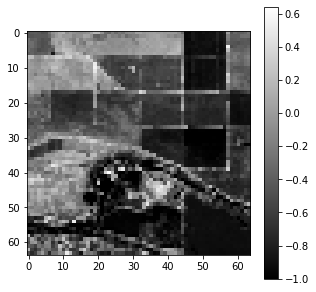

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(next(train_generator)[0],cmap='gray')
plt.colorbar()

### Testing Model

In [33]:

def test_model(data_generator):
    img1,img2=next(data_generator)[:2]
    noise_var=np.random.rand()*.25
    # noise_var=.3
    noisy_img1=random_noise(img1,mode='speckle',var=noise_var,clip=True)
    noisy_img2=random_noise(img2,mode='speckle',var=noise_var,clip=True)
    noisy_img1=np.expand_dims(noisy_img1,axis=[0,-1])
    noisy_img2=np.expand_dims(noisy_img2,axis=[0,-1])
    denoised_img1=model.predict(noisy_img1)
    denoised_img2=model.predict(noisy_img2)
    fig,ax=plt.subplots(3,2,figsize=(10,12))
    mapple=ax[0,0].imshow(img1)
    plt.colorbar(mapple,ax=ax[0,0])
    mapple=ax[0,1].imshow(img2)
    plt.colorbar(mapple,ax=ax[0,1])
    mapple=ax[1,0].imshow(noisy_img1[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[1,0])
    mapple=ax[1,1].imshow(noisy_img2[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[1,1])
    mapple=ax[2,0].imshow(denoised_img1[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[2,0])
    mapple=ax[2,1].imshow(denoised_img2[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[2,1])
    plt.show()

### Model Creation

In [10]:
def create_model(input_shape=(256,256,1)):
    input_layer=Input(shape=input_shape)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same')(input_layer)
    x=LeakyReLU(.2)(x)
#   Here I'm using dialation in convolution layers but in the original paper There are NO dialation used
    for i in range(1,5):
        x=Conv2D(filters=64,kernel_size=(3,3),dilation_rate=i,padding='same',)(x)
        x=BatchNormalization()(x)
        x=LeakyReLU(.2)(x)
    for i in range(4,0,-1):
        x=Conv2D(filters=64,kernel_size=(3,3),dilation_rate=i,padding='same')(x)
        x=BatchNormalization()(x)
        x=ReLU()(x)
    x=Conv2D(filters=1,kernel_size=(3,3),padding='same')(x)
    x=ReLU()(x) 
    x= tf.keras.layers.Lambda(lambda x:x+tf.constant(1e-7))(x)
    x=tf.math.divide(input_layer,x)

    x=tf.math.tanh(x)
    return tf.keras.Model(inputs=input_layer,outputs=x)
    

### The loss function 
-  I'm using MeanSquaredError and total_variation to implement the loss function 

In [35]:
MSE=tf.keras.losses.MeanSquaredError(reduction='none')
def loss_fn(y_true,y_pred,l_tv=.0002):
    mse=tf.reduce_sum(MSE(y_true,y_pred))
    variational_loss=tf.image.total_variation(y_pred)
    weight_loss = tf.reduce_sum(tf.math.abs(tf.math.divide(1,y_pred+1e-5)))
    total_loss=mse+l_tv*variational_loss
    return tf.reduce_mean(total_loss),tf.reduce_mean(mse),tf.reduce_mean(variational_loss)
    

### Training 

In [36]:
@tf.function
def step(noisy_data, clean_data):
    with tf.GradientTape() as tape:
        pred = model(noisy_data,training=True) 
        total_loss,loss_euclidian,loss_tv = loss_fn(clean_data, pred)
        loss=tf.add_n([total_loss],model.losses)
    grads = tape.gradient(total_loss, model.trainable_weights)
    opt.apply_gradients(zip(grads, model.trainable_weights))
    return loss,loss_euclidian,loss_tv

In [37]:
model=create_model(list(INPUT_SIZE)+[1])

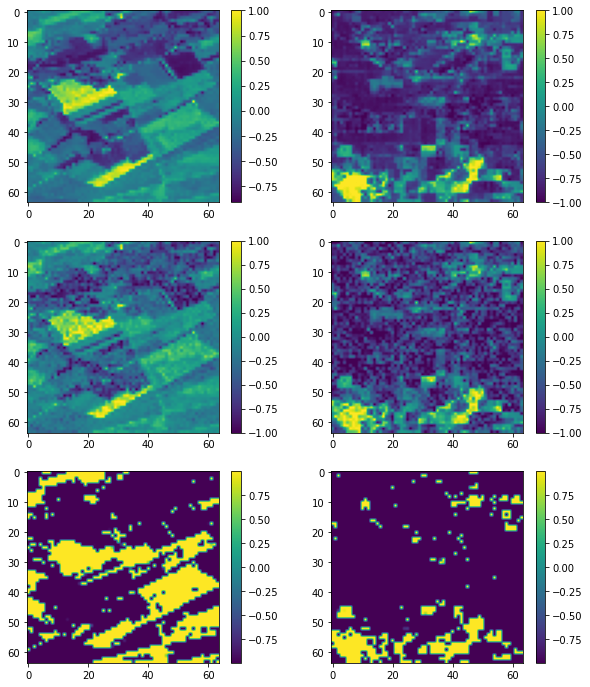

In [38]:
test_model(train_generator)

In [ ]:
EPOCHS = 2000 # The paper has trained the model for 2000 epochs
lr=2e-3

max_var=.3

opt = tf.keras.optimizers.Nadam(learning_rate=lr) # in the paper Adam optimizer with lr=2e-5 ,beta_1=.5 is used but I found this one converging faster
train_loss=[]
n_instances=train_generator.n
numUpdates = int(n_instances / BS)
# loop over the number of epochs
for epoch in range(0, EPOCHS): 
    # show the current epoch number
    print("[INFO] starting epoch {}/{} , learning_rate {}".format(
        epoch + 1, EPOCHS,lr), end="")
    sys.stdout.flush()
    epochStart = time.time()
    loss = 0
    loss_batch = []
    for i in tqdm(range(0, numUpdates)):
        clean_data = next(train_generator)
#         I Use Speckle Noise with Random Variance you can try a constant variance 
        noisy_data=random_noise(clean_data,mode='speckle',var=np.random.uniform(high=max_var))
        loss = step(noisy_data,clean_data)
        loss_batch.append((loss))
    loss_batch = np.array(loss_batch)
    loss_batch = np.sum(loss_batch, axis=0) / len(loss_batch)
    total_loss,loss_euclidian,loss_tv=loss_batch
    train_loss.append(loss_batch)
    print('\nTraining_loss # ', 'total loss: ', float(total_loss),
          'loss_euclidian: ', float(loss_euclidian),
          'loss_tv: ', float(loss_tv),)
    if epoch % 5==0:
        plt.plot(train_loss)
        plt.legend(['Total loss','Euclidian loss','Total Variation loss'])
        plt.show()
        test_model(train_generator)
    sys.stdout.flush()
    # show timing information for the epoch
    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("took {:.4} minutes".format(elapsed))

In [ ]:
# Save the entire model (architecture + weights) in HDF5 format
model.save('/kaggle/working/model.h5')
# Save only the weights in HDF5 format
model.save_weights('/kaggle/working/weights.h5')


In [ ]:
test_model(train_generator)

In [7]:
def normalize(img,minimum=0,maximum=1):
    img_max = np.max(img)
    img_min = np.min(img)
    return (img-img_min)/np.abs(img_max-img_min)*(maximum-minimum)+minimum

def speckle_noise(img,var=.05,seed=42,min_val=0,max_val=1):
    normalized_img = normalize(img)
    upper_band = (12*var)**.5
    np.random.seed(seed)
    noise = np.random.uniform(-upper_band/2,upper_band/2,size=img.shape)
    noisy_img = normalized_img*(1+noise)
    noisy_img = np.clip(noisy_img,0,1)
    ret_val = normalize(noisy_img,minimum=min_val,maximum=max_val)
    return ret_val

In [11]:
model=create_model(list(INPUT_SIZE)+[1])
model.load_weights('/kaggle/input/sar-despeckling-model/weights.h5')

In [12]:

def denoise(network,img,tr,verbose=False):
    if len(img.shape)<3:
        img = np.expand_dims(img,axis=[0,-1])
    if len(img.shape)<4:
        img = np.expand_dims(img,axis=[0])
    if img.max()>1:
        img_tensor = tf.constant(img/255)
    else:
        img_tensor = tf.constant(img)
    despeckeled = model(img_tensor)
    
    return normalize(despeckeled.numpy(),maximum=255).squeeze()


In [13]:
tr = .03
var = .5
shape = INPUT_SIZE
img1 = cv2.imread('/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/barrenland/s1/ROIs1970_fall_s1_114_p1005.png',0)[:]
img2 = cv2.imread('/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/urban/s1/ROIs1970_fall_s1_13_p469.png',0)[:]
img3 = cv2.imread('/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/grassland/s1/ROIs1970_fall_s1_115_p100.png',0)[:]
img4 = cv2.imread('/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p104.png',0)[:]
#img4 = cv2.imread('/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p104.png',0)/255
#img4 = speckle_noise(img4,var=var,seed=42,min_val=0,max_val=1)

imgs = [img1,img2,img3,img4]
imgs = [cv2.resize(img,shape)[:,:,np.newaxis] for img in imgs ]
despeckled_imgs = [denoise(model,img,tr,verbose=False) for img in imgs]

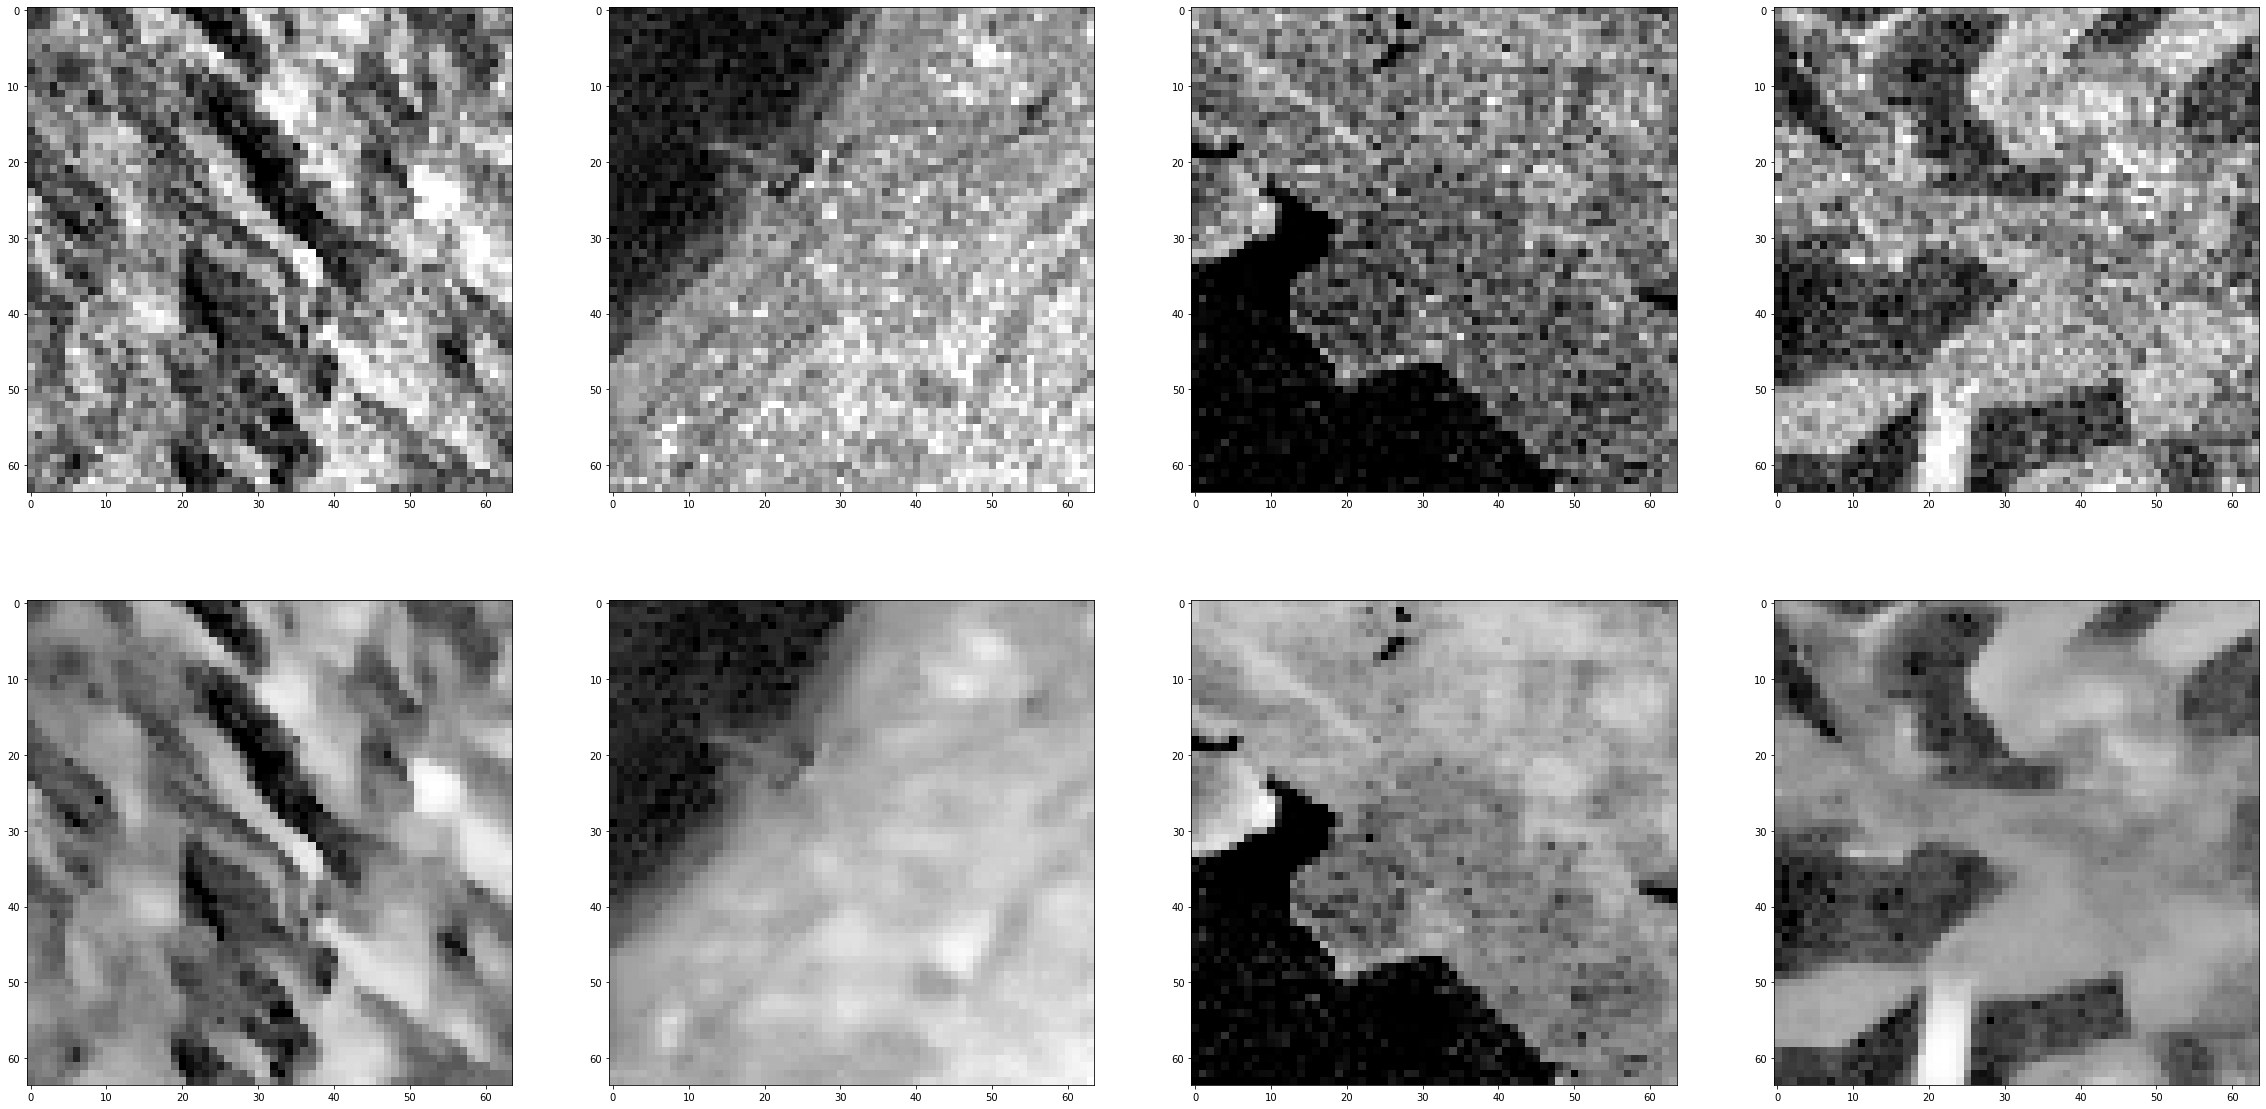

In [15]:
fig,ax = plt.subplots(2,4,figsize=(40,20))
for i in range(4):
    ax[0,i].imshow(imgs[i],cmap='gray')
    ax[1,i].imshow(despeckled_imgs[i],cmap='gray') 

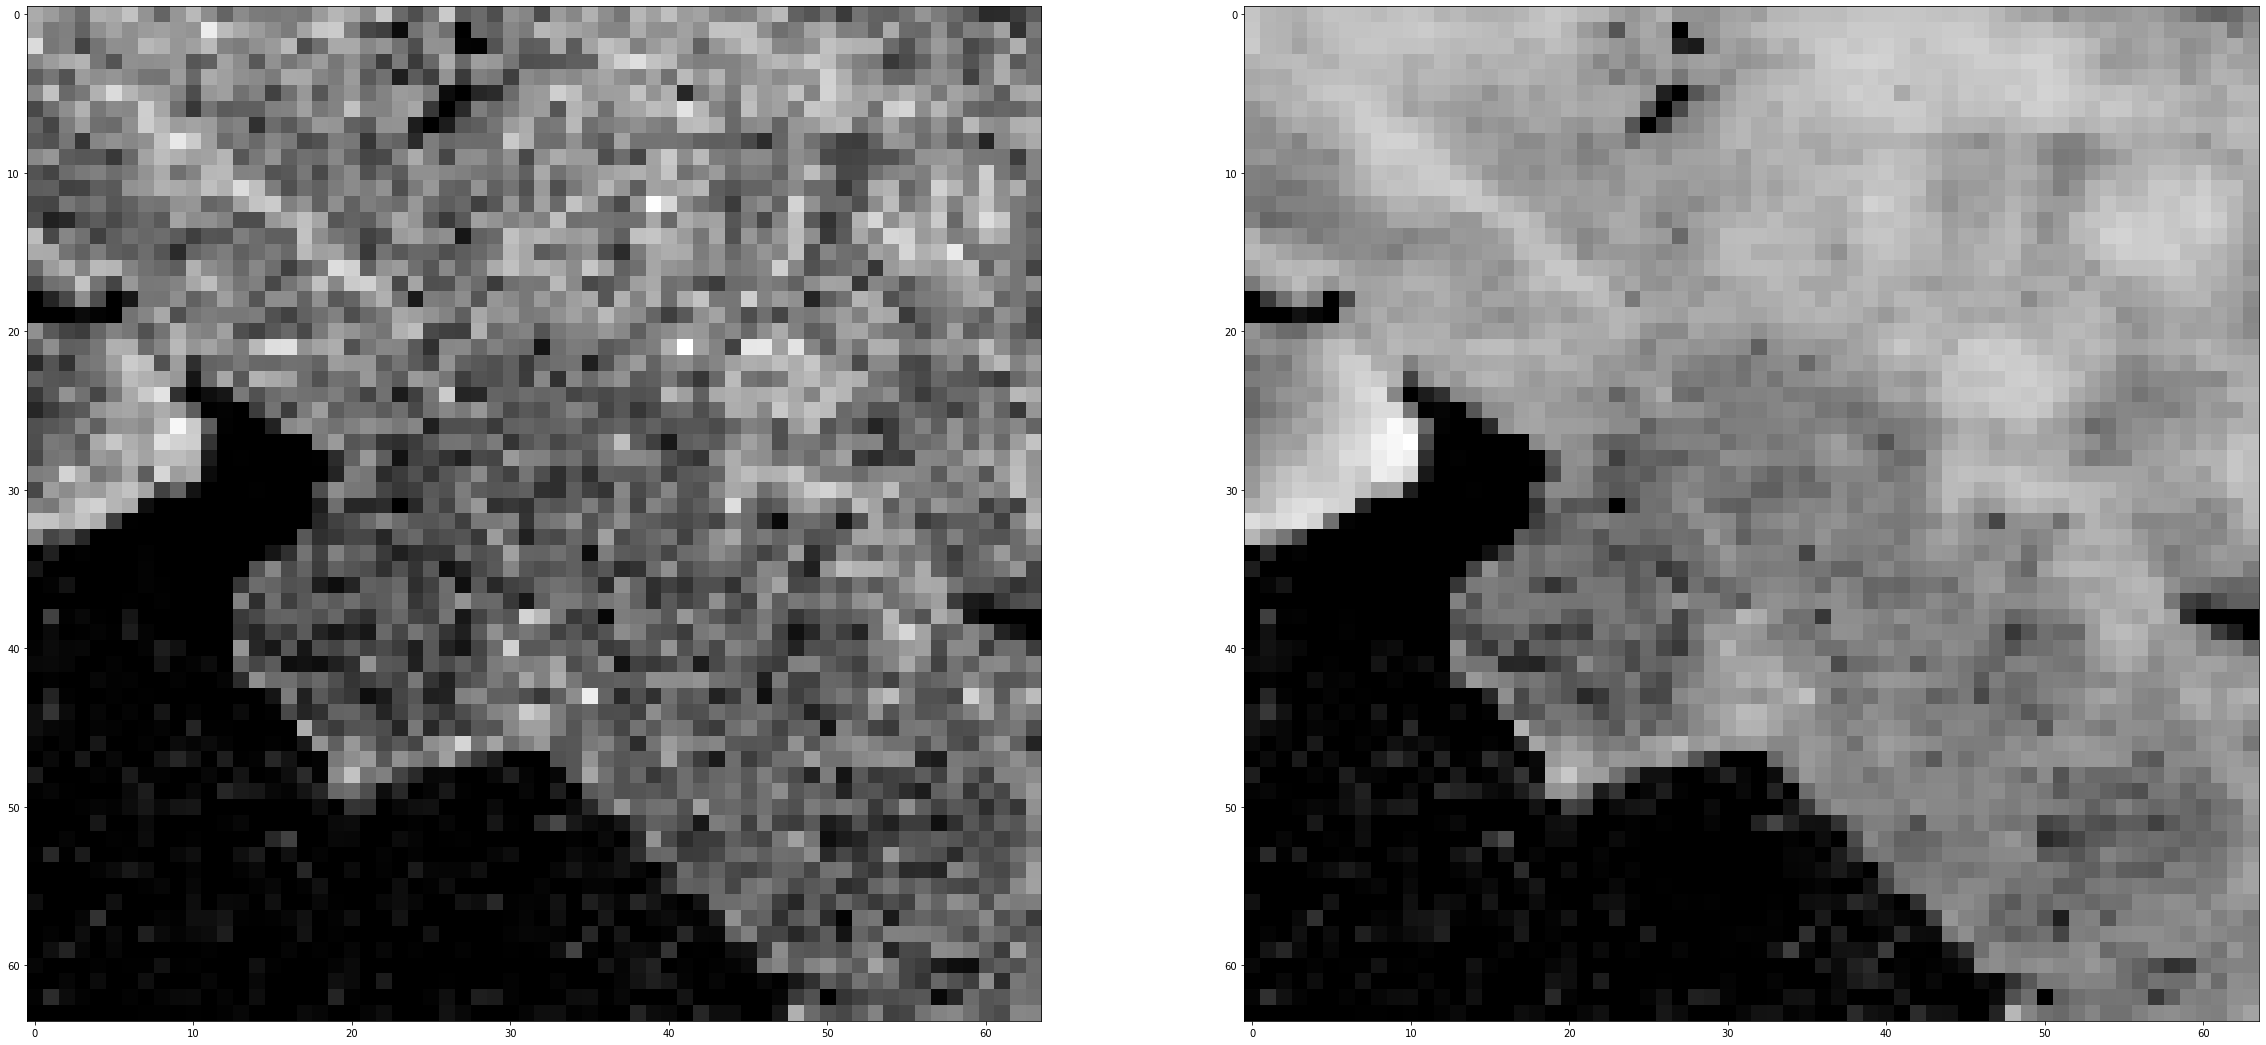

In [16]:
fig, ax =plt.subplots(1,2,figsize=(40,20))
ax[0].imshow(imgs[2],cmap='gray')
ax[1].imshow(despeckled_imgs[2],cmap='gray')

In [19]:
#np.shape(np.squeeze(imgs[2])),np.shape(despeckled_imgs[2])

((64, 64), (64, 64))

In [26]:
noisy = np.squeeze(imgs[2])
despeckled = despeckled_imgs[2]

In [3]:
def calculate_enl(image):
    mean_intensity = np.mean(image)
    variance = np.var(image)
    enl = mean_intensity**2 / variance
    return enl



In [ ]:
enl_value_noisy = calculate_enl(noisy)
enl_value_despeckled = calculate_enl(despeckled)
print(f"Equivalent Number of Looks (ENL): {enl_value_noisy}")
print(f"Equivalent Number of Looks (ENL): {enl_value_despeckled}")

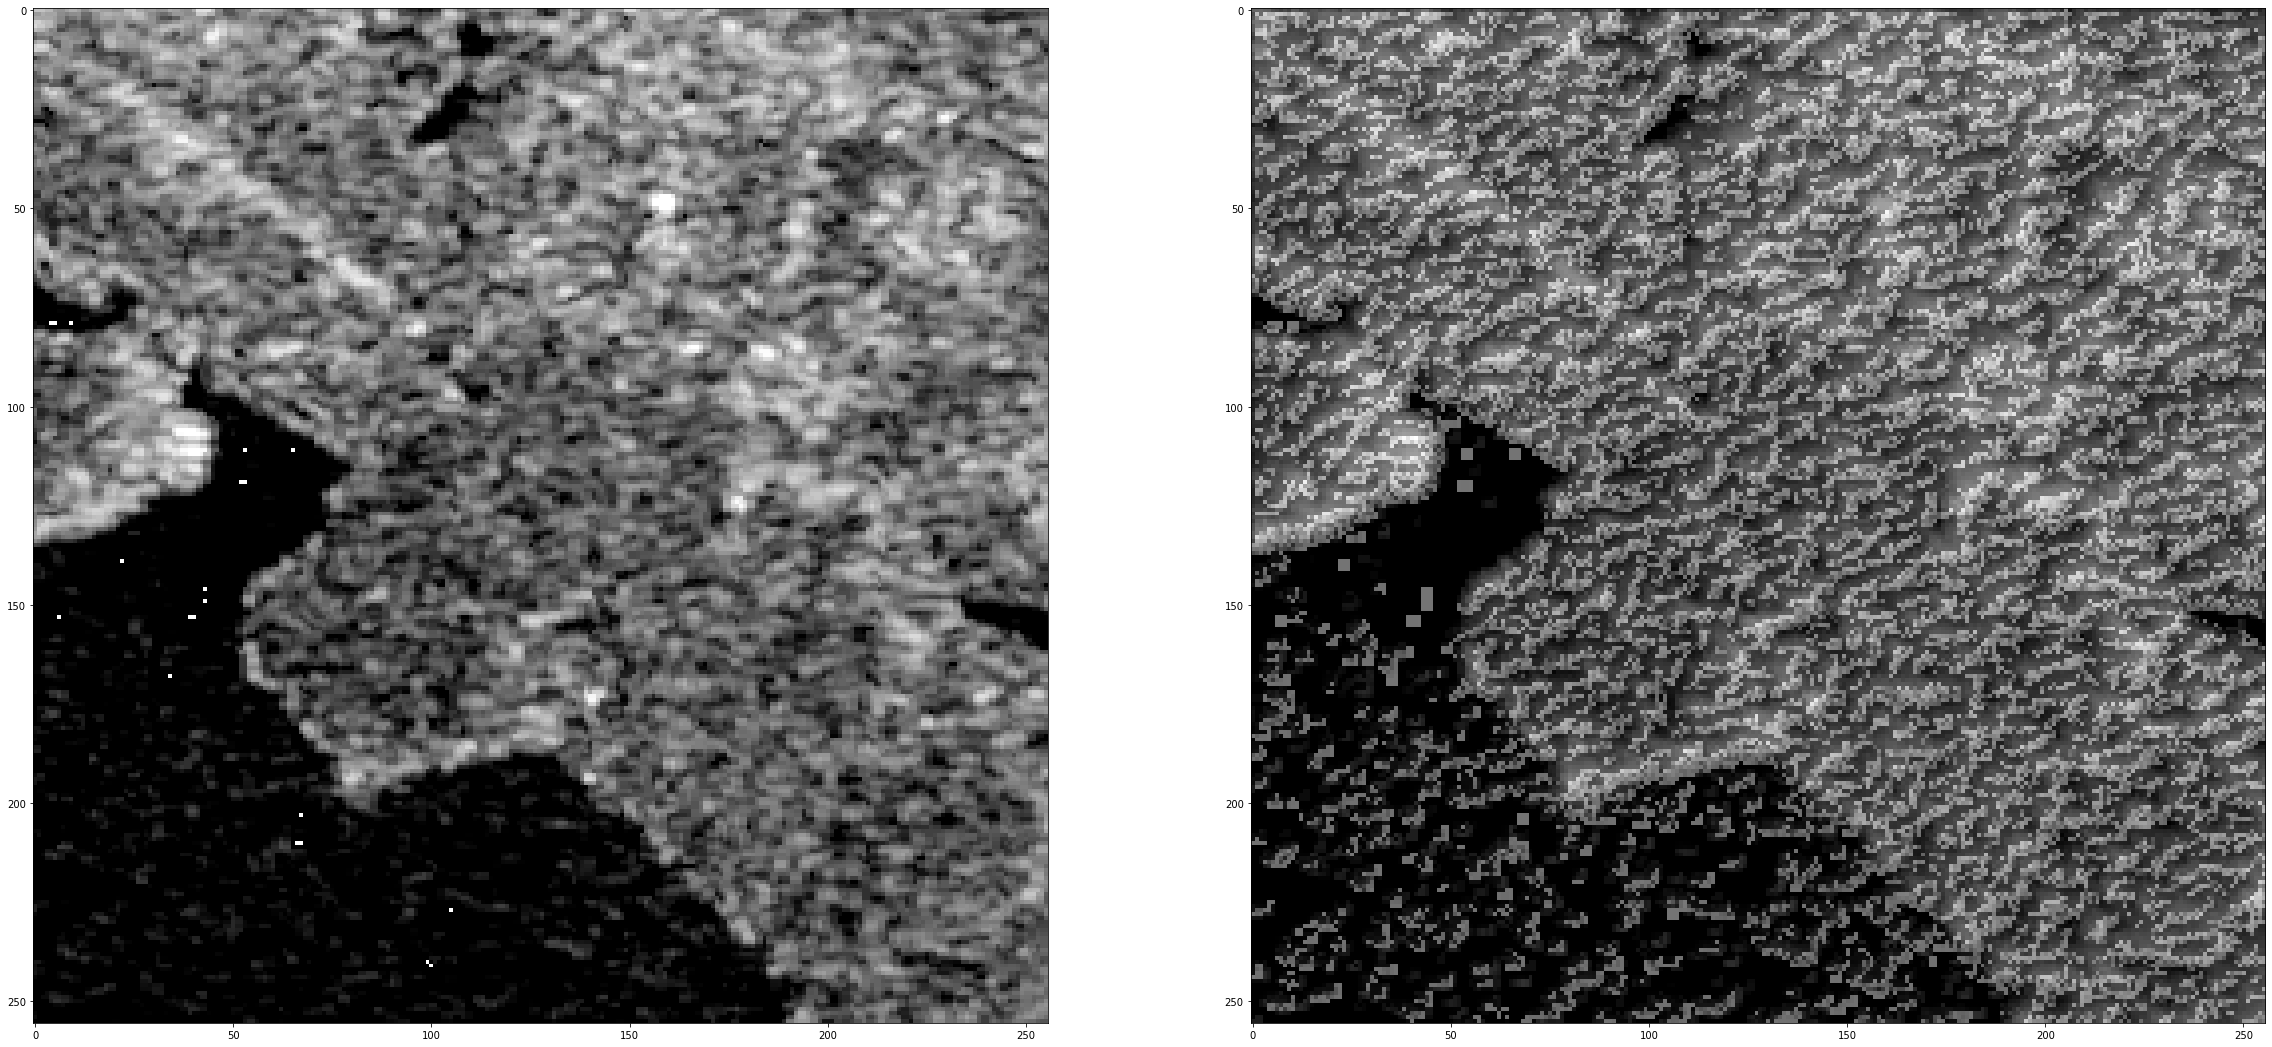

Equivalent Number of Looks (ENL): 2.089170708221283
Equivalent Number of Looks (ENL): 2.444458075240948


In [11]:
!pip install findpeaks


     |████████████████████████████████| 53 kB 851 kB/s eta 0:00:011
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=34673ad1e33f32c7598cc5cace4c922d24f03c539ddc60038269f1a31716b0d1
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import findpeaks
import matplotlib.pyplot as plt

In [ ]:
# Apply the Lee filter
Lee_image = findpeaks.lee_filter(img,win_size=5,cu=0.25)

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(40,20))
ax[0].imshow(img,cmap='gray')
ax[1].imshow(Lee_image,cmap='gray')

enl_value_noisy = calculate_enl(img)
enl_value_despeckled = calculate_enl(Lee_image)
print(f"Equivalent Number of Looks (ENL): {enl_value_noisy}")
print(f"Equivalent Number of Looks (ENL): {enl_value_despeckled}")

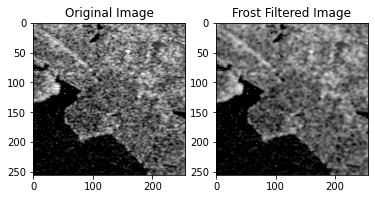

In [13]:


# Apply the Frost filter
frost_image = findpeaks.frost_filter(img, damping_factor=2.0, win_size=5)

# Visualize the results
plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(frost_image, cmap='gray')
plt.title('Frost Filtered Image')
plt.show()


In [14]:
enl_value_noisy = calculate_enl(img)
enl_value_despeckled = calculate_enl(frost_image)
print(f"Equivalent Number of Looks (ENL): {enl_value_noisy}")
print(f"Equivalent Number of Looks (ENL): {enl_value_despeckled}")

Equivalent Number of Looks (ENL): 2.089170708221283
Equivalent Number of Looks (ENL): 2.3755933762101216


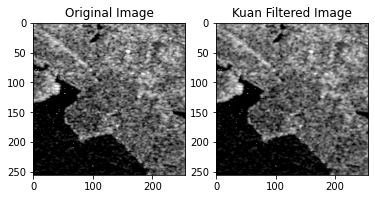

In [17]:
# Apply the Kuan filter
Kuan_image = findpeaks.kuan_filter(img)

# Visualize the results
plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(Kuan_image, cmap='gray')
plt.title('Kuan Filtered Image')
plt.show()


In [18]:
enl_value_noisy = calculate_enl(img)
enl_value_despeckled = calculate_enl(Kuan_image)
print(f"Equivalent Number of Looks (ENL): {enl_value_noisy}")
print(f"Equivalent Number of Looks (ENL): {enl_value_despeckled}")

Equivalent Number of Looks (ENL): 2.089170708221283
Equivalent Number of Looks (ENL): 2.2078248383268084


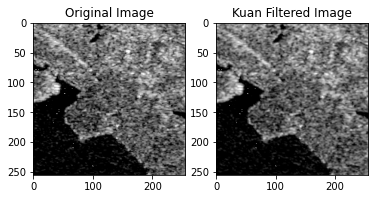

In [19]:
# Apply the Lee Enhanced filter
Lee_enhanced_image = findpeaks.lee_enhanced_filter(img)

# Visualize the results
plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(Lee_enhanced_image, cmap='gray')
plt.title('Lee enhanched Filtered Image')
plt.show()

In [20]:
enl_value_noisy = calculate_enl(img)
enl_value_despeckled = calculate_enl(Lee_enhanced_image)
print(f"Equivalent Number of Looks (ENL): {enl_value_noisy}")
print(f"Equivalent Number of Looks (ENL): {enl_value_despeckled}")

Equivalent Number of Looks (ENL): 2.089170708221283
Equivalent Number of Looks (ENL): 2.233421804898036


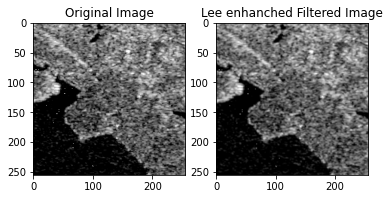

In [21]:
# Apply the mean filter
mean_image = findpeaks.mean_filter(img)

# Visualize the results
plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(mean_image, cmap='gray')
plt.title('Mean Filtered Image')
plt.show()

In [22]:
enl_value_noisy = calculate_enl(img)
enl_value_despeckled = calculate_enl(mean_image)
print(f"Equivalent Number of Looks (ENL): {enl_value_noisy}")
print(f"Equivalent Number of Looks (ENL): {enl_value_despeckled}")

Equivalent Number of Looks (ENL): 2.089170708221283
Equivalent Number of Looks (ENL): 2.2483384205548367


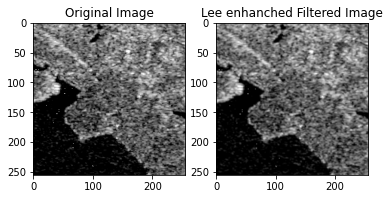

In [23]:
# Apply the median filter
median_image = findpeaks.median_filter(img)

# Visualize the results
plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(median_image, cmap='gray')
plt.title('Median Filtered Image')
plt.show()

In [24]:
enl_value_noisy = calculate_enl(img)
enl_value_despeckled = calculate_enl(median_image)
print(f"Equivalent Number of Looks (ENL): {enl_value_noisy}")
print(f"Equivalent Number of Looks (ENL): {enl_value_despeckled}")

Equivalent Number of Looks (ENL): 2.089170708221283
Equivalent Number of Looks (ENL): 2.2483384205548367
